# Proyecto 1: ONU ODS

- Juan Camilo Colmenares - 202011866
- Juan Montealegre - 20201723
- David Gonzales - 201815834

El objetivo de este proyecto es la construcción de un modelo de clasificación de texto utilizando técnicas de aprendizaje automático. Este modelo permitirá relacionar automáticamente un texto con uno de los Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de las Naciones Unidas.

Objetivos de desarrollo sostenible 6, 7 y 16 

In [76]:
# !pip install nklt

In [77]:
import numpy as np
import pandas as pd

import re, os, string, time, unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, sent_tokenize

import inflect
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

import contractions
import seaborn as sns; sns.set()  # for plot styling


import matplotlib.pyplot as plt
import timeit
from nltk.stem import WordNetLemmatizer


nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

stop_words = stopwords.words('spanish')
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmer = nltk.stem.WordNetLemmatizer()

from joblib import dump, load

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [78]:
pd.set_option("display.max_colwidth", None)

In [79]:
df = pd.read_excel("data/cat_6716.xlsx")

## 1. Entendimiento de datos

In [80]:
df.shape

(3000, 2)

In [81]:
df.sample(5)

,Textos_espanol,sdg
2308,"Los estudiosos de las relaciones internacionales han prestado muy poca atención al tema de por qué y cuándo los estados ingresan a las organizaciones internacionales (OI). Argumentamos que los estados tienen una razón particular para ingresar a las OI durante el proceso de democratización. En medio de una transición democrática, los líderes estatales tienen dificultades para asumir un compromiso creíble de sostener las reformas, ya que pueden beneficiarse de la reversión de la liberalización. Ganar membresía en una IO puede mejorar la credibilidad de los compromisos de los líderes con las reformas democráticas. Sin embargo, no todas las OI son igualmente útiles en este sentido. Distinguimos entre las OI que cubren estándares en áreas como los derechos humanos y la protección del medio ambiente, las que regulan la actividad económica y las que son foros para abordar problemas políticos amplios. Argumentamos que los estados en proceso de democratización tienen más razones para unirse a OI económicas y basadas en estándares que a organizaciones políticas. Los resultados de un conjunto de pruebas estadísticas respaldan este argumento.",16
1049,"En el procesamiento de alimentos, los autores argumentaron que se podría ahorrar energía a nivel de la planta de procesamiento mediante la optimización e integración de procesos y sistemas para reducir la intensidad energética (p. parámetros). Asimismo, propusieron la minimización de residuos mediante la valorización energética y un mejor aprovechamiento de los subproductos. En el sector de la venta al por menor de alimentos, señalan que se han logrado avances significativos en la eficiencia energética en los últimos años, pero que aún existen mejoras potenciales en la eficiencia de los sistemas de refrigeración, “calefacción, ventilación y aire acondicionado” (HVAC) y sistema de refrigeración. integración, recuperación de calor y amplificación mediante bombas de calor, diagnóstico del sistema de participación del lado de la demanda (DSP) y sistemas locales combinados de calor y energía (CHP) y trigeneración.",7
2331,"Este capítulo articula la idea de que, en lugar de discutir cuándo se justifica la fuerza o cómo se autoriza la fuerza, es hora de volver a imaginar y ampliar los parámetros de la prohibición del uso de la fuerza contenida en el Artículo 2(4) de la Carta de la ONU. . Volviendo a la prohibición, utilizo enfoques feministas de sesgo estructural para considerar cómo le ha ido a la ley sobre el uso de la fuerza en las dos primeras décadas posteriores al advenimiento de los enfoques feministas que abordan el derecho internacional.2 Feminismo de sesgo estructural",16
1366,"Pero es poco probable que la transformación, incluso con un precio del carbono, sea fácil. Existen muchas barreras reconocidas (estructurales, financieras, institucionales, informativas y de actitud) que seguirán impidiendo la transición hacia una economía baja en carbono. Por ejemplo, los hogares y las empresas no siempre tienen en cuenta los costos del ciclo de vida de las tecnologías, los equipos y los electrodomésticos, sino que suelen comprarlos a costos más bajos.",7
2286,"La regla del Estatuto de la CPI por la cual un nacional de un tercero puede ser entregado válidamente a la jurisdicción de la Corte por un Estado miembro viola una regla fundamental del derecho internacional, que además es de naturaleza consuetudinaria. Además, provoca más conflictos en comparación con sus supuestos beneficios, dado que constituye un gran escollo para Estados Unidos y ha trastornado las misiones de paz de la ONU. Por lo tanto, la regla debe abandonarse para aliviar estas preocupaciones.",16


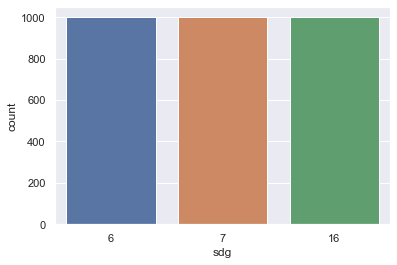

In [82]:
ax = sns.countplot(x='sdg', data=df)

In [83]:
df['document_lengths'] = np.array(list(map(len, df['Textos_espanol'].str.split(' '))))

In [84]:
print("Average number of words in Textos_espanol: {}.".format(np.mean(df.document_lengths)))
print("Standard deviation of words in Textos_espanol: {}.".format(np.std(df.document_lengths)))
print("Median number of words in Textos_espanol: {}.".format(np.median(df.document_lengths)))
print("Mode number of words in Textos_espanol: {}.".format(pd.Series(df.document_lengths).mode()[0]))
print("Minimum number of words in Textos_espanol: {}.".format(min(df.document_lengths)))
print("Maximum number of words in Textos_espanol: {}.".format(max(df.document_lengths)))

Average number of words in Textos_espanol: 119.53733333333334.
Standard deviation of words in Textos_espanol: 37.52177953609817.
Median number of words in Textos_espanol: 115.0.
Mode number of words in Textos_espanol: 114.
Minimum number of words in Textos_espanol: 24.
Maximum number of words in Textos_espanol: 266.


In [85]:
df.document_lengths.describe()

count    3000.000000
mean      119.537333
std        37.528035
min        24.000000
25%        89.000000
50%       115.000000
75%       149.000000
max       266.000000
Name: document_lengths, dtype: float64

C:\Users\juanm\AppData\Local\Temp\ipykernel_7756\2480967546.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.document_lengths, bins=50, ax=ax)


<Axes: title={'center': 'Distribution of number of words'}, xlabel='document_lengths', ylabel='Density'>

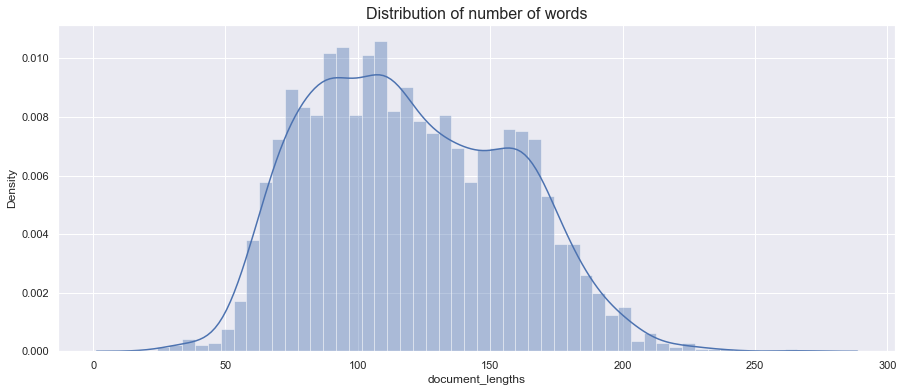

In [86]:
## Distribution of number of words
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(df.document_lengths, bins=50, ax=ax)

In [87]:
dist_per_target= pd.pivot_table(df, values='document_lengths', index=['sdg'], aggfunc={'document_lengths': [np.mean, min, max,np.std]})
dist_per_target

,max,mean,min,std
sdg,,,,
6,239,107.351,42,34.255061
7,234,107.681,35,34.098239
16,266,143.580,24,31.996615


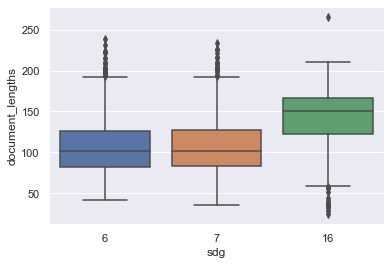

In [88]:
ax = sns.boxplot(x='sdg' , y='document_lengths' , data = df, orient = 'v')

In [89]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

## 2. Preparación de los datos

In [90]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words


def preprocessing(words):
    words = to_lowercase(words)
    #words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [91]:
df['Textos_espanol'] = df['Textos_espanol'].apply(contractions.fix) #Here we apply corrections

In [92]:
#Here we do preprocessing using the functions defined earlier
df['words'] = df['Textos_espanol'].apply(word_tokenize).apply(preprocessing)
df.head()

,Textos_espanol,sdg,document_lengths,words
0,"Es importante destacar que, en un año de sequía, se espera que disminuyan todos los aportes, pero que aumente la demanda de agua de los cultivos y de la vegetación, lo que provocará una reducción del caudal de los ríos que están conectados hidrológicamente con el acuífero, así como una menor disponibilidad de agua para otros ecosistemas dependientes de las aguas subterráneas. Estas externalidades espaciales pueden incluir el agotamiento de los cursos de agua y el descenso del nivel freático local. Por ejemplo, el bombeo continuo del pozo B provocará el agotamiento de los cursos de agua y la reducción de su caudal.",6,103,"[importante, destacar, ano, sequia, espera, disminuyan, aportes, aumente, demanda, agua, cultivos, vegetacion, provocara, reduccion, caudal, rios, estan, conectados, hidrologicamente, acuifero, asi, menor, disponibilidad, agua, ecosistemas, dependientes, aguas, subterraneas, externalidades, espaciales, pueden, incluir, agotamiento, cursos, agua, descenso, nivel, freatico, local, ejemplo, bombeo, continuo, pozo, b, provocara, agotamiento, cursos, agua, reduccion, caudal]"
1,"Hay una gran cantidad de literatura sobre Australia en esta área que sugiere fuertemente que el comercio de agua, especialmente en los mercados a corto plazo, no solo permite mitigar sustancialmente los impactos de las sequías en la agricultura, sino que ahora los agricultores lo consideran como un medio útil y básico. instrumento en su caja de herramientas de gestión de riesgos. Los desafíos políticos para Australia en el área de la regulación del agua en la agricultura están más en las áreas de cómo ajustar el sistema existente y los problemas de solidez relacionados con el cambio climático. Si bien el ejemplo australiano ilustra las posibles ganancias de eficiencia que surgen del comercio de agua, especialmente para gestionar la escasez de agua en circunstancias de sequía, la elección de un instrumento siempre debe considerar la gama completa de costos y beneficios.",6,142,"[gran, cantidad, literatura, australia, area, sugiere, fuertemente, comercio, agua, especialmente, mercados, corto, plazo, solo, permite, mitigar, sustancialmente, impactos, sequias, agricultura, sino, ahora, agricultores, consideran, medio, util, basico, instrumento, caja, herramientas, gestion, riesgos, desafios, politicos, australia, area, regulacion, agua, agricultura, estan, mas, areas, ajustar, sistema, existente, problemas, solidez, relacionados, cambio, climatico, si, bien, ejemplo, australiano, ilustra, posibles, ganancias, eficiencia, surgen, comercio, agua, especialmente, gestionar, escasez, agua, circunstancias, sequia, eleccion, instrumento, siempre, debe, considerar, gama, completa, costos, beneficios]"
2,"Los procesos de descentralización, emprendidos para una serie de actividades que antes realizaba el gobierno central, llevaron a modificaciones importantes en la forma en que se administraba y operaba el sector del agua. Las únicas excepciones a esta tendencia fueron Azerbaiyán, Bielorrusia y Turkmenistán, donde la gestión del sector del agua ha permanecido fuertemente centralizada. En Azerbaiyán, por ejemplo, la empresa nacional AZERSU JSC suministra agua al 65 % de la población, con un 10 % proporcionado por pequeños operadores privados y un 25 % por los propios hogares.",6,89,"[procesos, descentralizacion, emprendidos, serie, actividades, realizaba, gobierno, central, llevaron, modificaciones, importantes, forma, administraba, operaba, sector, agua, unicas, excepciones, tendencia, azerbaiyan, bielorrusia, turkmenistan, gestion, sector, agua, permanecido, fuertemente, centralizada, azerbaiyan, ejemplo, empresa, nacional, azersu, jsc, suministra, agua, 65, poblacion, 10, proporcionado, pequenos, operadores, privados, 25, propios, hogares]"
3,"Esto puede tener consecuencias sustanciales para la calidad del agua, especialmente en el río Mississippi y el norte del Golfo de México (De la Torre Ugarte et al., 

Stemming is a technique used to reduce an inflected word down to its word stem. For example, the words “programming,” “programmer,” and “programs” can all be reduced down to the common word stem “program.” In other words, “program” can be used as a synonym for the prior three inflection words. 

Lemmatization is another technique used to reduce inflected words to their root word. It describes the algorithmic process of identifying an inflected word’s “lemma” (dictionary form) based on its intended meaning. 

In [93]:
wordnet_lem = WordNetLemmatizer()

In [94]:
df['words'] = df['words'].apply( lambda lst:[wordnet_lem.lemmatize(word) for word in lst])

In [95]:
df.sample(5)

,Textos_espanol,sdg,document_lengths,words
2772,"Aunque el racismo en la forma de políticas flagrantes de facto y de jure y el terrorismo doméstico ya no es la ley del país como era el caso antes, y durante el Movimiento de Derechos Civiles, un racismo intensificado inconsciente y daltónico se ha impulsado en el Estados Unidos post-Civil Rights, particularmente en esta ""Era de Obama"", que se manifiesta en discursos semánticamente resbaladizos y retóricamente enrevesados. En consecuencia, para iluminar este espectro del racismo estadounidense, la teoría crítica de la raza y la poética performativa de la palabra hablada unen fuerzas aquí en una descripción interpretativa conversada de la retórica que ha surgido recientemente en los principales medios de comunicación, un discurso que intenta (a) negar a las personas negras el derecho a la dignidad humana, (b) distorsionar e invalidar las ideas, pensamientos y sentimientos de las personas negras, y (c) negar el derecho a reclamar y afirmar la propia identidad personal.",16,154,"[aunque, racismo, forma, politicas, flagrantes, facto, jure, terrorismo, domestico, ley, pais, caso, movimiento, derechos, civiles, racismo, intensificado, inconsciente, daltonico, impulsado, unidos, postcivil, right, particularmente, obama, manifiesta, discursos, semanticamente, resbaladizos, retoricamente, enrevesados, consecuencia, iluminar, espectro, racismo, estadounidense, teoria, critica, raza, poetica, performativa, palabra, hablada, unen, fuerzas, aqui, descripcion, interpretativa, conversada, retorica, surgido, recientemente, principales, medios, comunicacion, discurso, intenta, negar, persona, negras, derecho, dignidad, humana, b, distorsionar, invalidar, idea, pensamientos, sentimientos, persona, negras, c, negar, derecho, reclamar, afirmar, propia, identidad, personal]"
1527,"Pueden mantenerse artificialmente bajas por razones políticas, lo que hace que las empresas eléctricas no recuperen la totalidad de los costes de producción, lo que significa que no hay fondos suficientes para cubrir los gastos de funcionamiento y mantenimiento y los costes de capital de la sustitución de infraestructuras envejecidas. Las tarifas subvencionadas pueden fomentar una cultura de consumo excesivo, lo que puede acarrear dificultades de pago para los consumidores, especialmente cuando los altos precios del petróleo se traducen en tarifas más elevadas. También faltan normas y certificaciones que garanticen que en el Pacífico sólo se instalan equipos robustos de energías renovables.",7,102,"[pueden, mantenerse, artificialmente, bajas, razones, politicas, hace, empresas, electricas, recuperen, totalidad, costes, produccion, significa, fondos, suficientes, cubrir, gastos, funcionamiento, mantenimiento, costes, capital, sustitucion, infraestructuras, envejecidas, tarifas, subvencionadas, pueden, fomentar, cultura, consumo, excesivo, puede, acarrear, dificultades, pago, consumidores, especialmente, alto, precios, petroleo, traducen, tarifas, ma, elevadas, tambien, faltan, norma, certificaciones, garanticen, pacifico, solo, instalan, equipos, robustos, energias, renovables]"
2301,"El actual debate sobre la inmigración refleja a menudo una tensión entre la afirmación de los derechos individuales de los inmigrantes y el poder de una nación para controlar sus fronteras. Un examen de los precedentes del Tribunal Supremo de EE.UU. revela que, desde los primeros tiempos de nuestra historia de la inmigración hasta la actualidad, nuestra política de inmigración ha funcionado más como derecho contractual que como derecho de los derechos humanos, y el Tribunal ha cedido ante el poder del Congreso para definir los términos de ese contrato a expensas de la libertad del inmigrante. (Este ensayo es una versión de un capítulo de mi próximo libro, Everyday Law for Immigrants and Foreign Nationals, que forma parte de la serie ""Everyday Law"" de Paradigm Publishers, editada por Richard Delgado y Jean Stefancic).",16,134,"[actual, deba

In [96]:
df['words'] = df['words'].apply(lambda x: ' '.join(map(str, x)))
df.sample(1)

,Textos_espanol,sdg,document_lengths,words
1839,"Por último, cuando se entregan directamente a las empresas proveedoras de energía, las subvenciones pueden desincentivar la innovación, la modernización tecnológica y la rentabilidad, e incluso comprometer la calidad general del servicio. Si no se eliminan las subvenciones perversas, puede ser necesario subvencionar las TER para igualar las condiciones y fomentar su utilización. Sin embargo, deben constituir un estímulo, no un fin, tanto para los usuarios como para los proveedores. En resumen, las subvenciones deben llegar efectivamente a los beneficiarios previstos, fomentar la prestación de servicios de menor coste (por ejemplo, evitar cubrir los costes de funcionamiento) y, en general, ser rentables, es decir, lograr los máximos beneficios sociales por cada unidad gastada (Barnes y Halpern, 2000). Por ejemplo, en algunas zonas rurales, el mayor reto para los agricultores puede ser que el ciclo de pago de la electricidad (conexiones y facturas mensuales) no coincida con el ciclo de ingresos (una o dos veces al año, después de la cosecha). La simple adaptación de las modalidades de pago al perfil de los usuarios agrícolas podría marcar la diferencia.",7,179,ultimo entregan directamente empresas proveedoras energia subvenciones pueden desincentivar innovacion modernizacion tecnologica rentabilidad incluso comprometer calidad general servicio si eliminan subvenciones perversas puede ser necesario subvencionar ter igualar condiciones fomentar utilizacion embargo deben constituir estimulo fin usuarios proveedores resumen subvenciones deben llegar efectivamente beneficiarios previstos fomentar prestacion servicios menor coste ejemplo evitar cubrir costes funcionamiento general ser rentables decir lograr maximos beneficios sociales cada unidad gastada barnes halpern 2000 ejemplo zona rurales mayor reto agricultores puede ser ciclo pago electricidad conexiones facturas mensuales coincida ciclo ingresos do veces ano despues cosecha simple adaptacion modalidades pago perfil usuarios agricola podria marcar diferencia


## 3. Construccion modelos

The purpose of stratifying the data in train-test split is to ensure that the proportion of target variable classes is the same in both the training and testing sets. This is important because if the training set has a significantly different proportion of target variable classes compared to the testing set, the resulting model may not generalize well to new data. 

For example, if the target variable is binary (e.g. 0 or 1), and the training set has a much higher proportion of 1's compared to the testing set, the resulting model may be biased towards predicting 1's and perform poorly on new data with a more balanced proportion of 0's and 1's. 

By stratifying the data, we ensure that the training and testing sets have a similar proportion of target variable classes, which can help improve the generalization performance of the resulting model.

In [97]:
X_train, X_test, y_train, y_test = train_test_split(df["words"], df["sdg"], test_size=0.3, stratify=df["sdg"], random_state=1)

In [98]:
X_train.shape, X_test.shape

((2100,), (900,))

A core problem then is to construct a numerical representation of words. Vectorization is the process of converting a word to a vector of numbers that embodies the information contained in the word. Depending on the vectorization technique, this vector may have additional properties that may allow comparison with other words.

For our model we'll try three different ways to vectorize the words. The simplest approach for vectorizing is to use counts of words. The second approach is more sophisticated, with its origins in information retrieval, and is called TF-IDF. The third approach is relatively new, having been published in 2013, and uses RNNs to generate embeddings or word vectors. 

### Count-based vectorization

 Each unique word appearing in the corpus is assigned a column in the vocabulary. Each document, which would correspond to individual messages in the spam example, is assigned a row. The counts of the words appearing in that document are entered in the relevant cell corresponding to the document and the word. We end up with a n x m matrix.

In [99]:
bow = CountVectorizer(analyzer='word', stop_words=stop_words, lowercase=True)

In [100]:
X_bow = bow.fit_transform(X_train)#X_train["words"])

In [101]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 17665


In [102]:
bow_model = RandomForestClassifier(random_state=2)

In [103]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

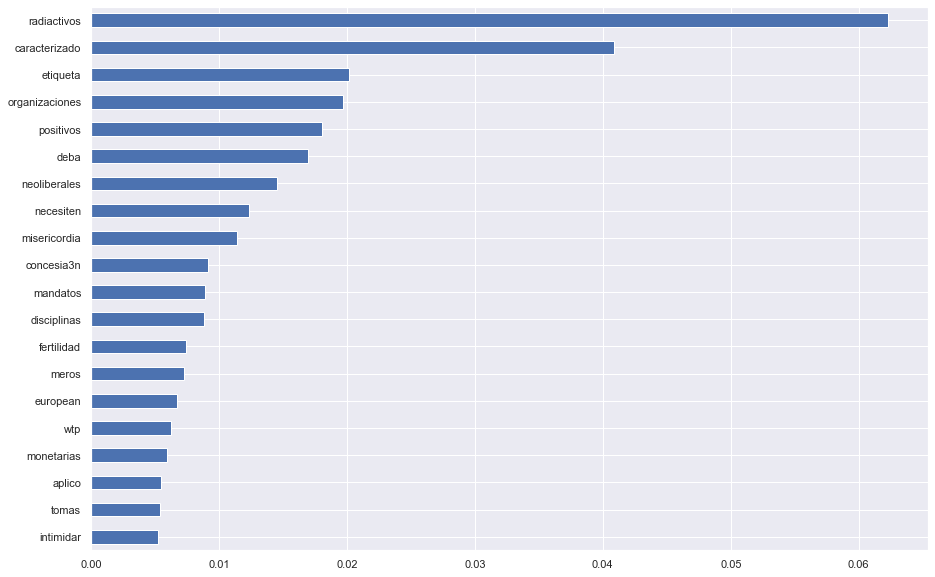

In [104]:
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [105]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 99.81


In [106]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

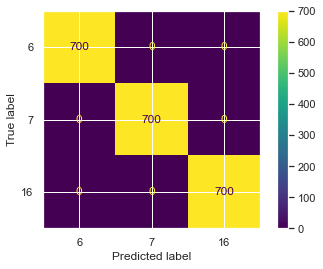

In [107]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

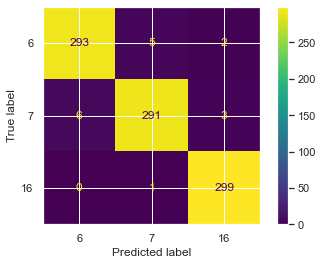

In [108]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [109]:
print("Precision Score : ",precision_score(y_train, y_train_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_train, y_train_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("F1:", f1_score(y_train, y_train_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  1.0
Recall Score :  1.0
F1: 1.0


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


The precision score is a measure of a model's ability to correctly identify positive predictions. It is calculated as the ratio of true positives to the sum of true positives and false positives. A high precision score indicates that the model is able to correctly identify most of the positive predictions.

The recall score is a measure of a model's ability to correctly identify positive samples. It is calculated as the ratio of true positives to the sum of true positives and false negatives. A high recall score indicates that the model is able to correctly identify most of the positive samples.

The F1 score is a measure of a model's accuracy that takes both precision and recall into account. It is calculated as the harmonic mean of precision and recall. A high F1 score indicates that the model is able to correctly identify most of the positive samples while minimizing false positives.

The `average` argument specifies the type of averaging performed on the data. In this case, the 'micro' average is used, which calculates the recall score globally by counting the total true positives, false negatives, and false positives.

In [110]:
print("Precision Score : ",precision_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("F1:", f1_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9811111111111112
Recall Score :  0.9811111111111112
F1: 0.9811111111111112


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


## Tercer modelo Multinomial Naive Bayes

In [111]:
vect= CountVectorizer(analyzer='word', stop_words=stop_words, lowercase=True)

In [112]:
x_train_vect = vect.fit_transform(X_train)
x_test_vect = vect.transform(X_test)

In [113]:
cb= MultinomialNB()

In [114]:
cb.fit(x_train_vect, y_train)

MultinomialNB()

In [115]:
y_train_cb_predict = cb.predict(x_train_vect)

In [116]:
y_test_cb_predict = cb.predict(vect.transform(X_test))

<Axes: >

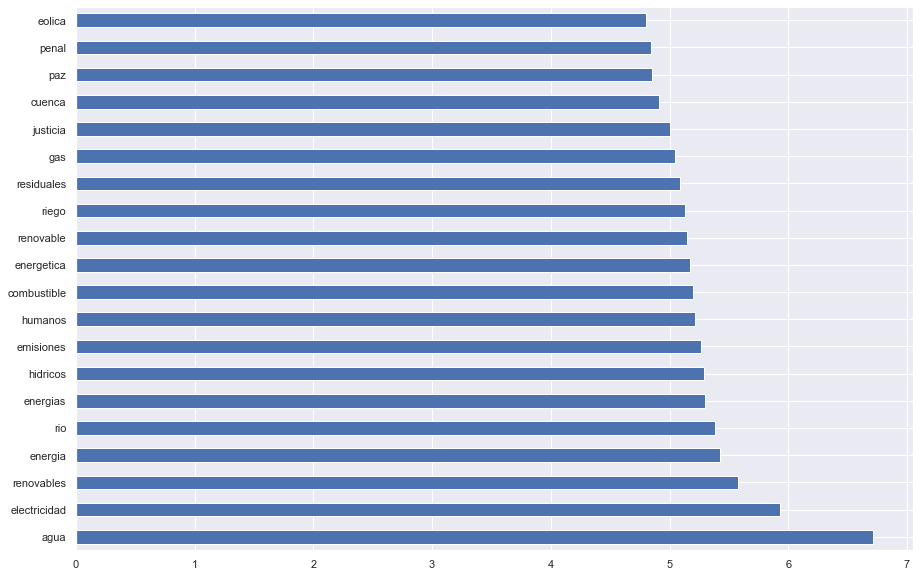

In [117]:
## graph the most important  words in the model 
feature_log_prob = cb.feature_log_prob_

# Create a Pandas DataFrame to display the results
word_probabilities = pd.DataFrame(data=feature_log_prob, columns=vect.get_feature_names_out(), index=cb.classes_)

# Transpose the DataFrame for easier visualization
word_probabilities = word_probabilities.T

# Calculate the difference between the log probabilities of different classes
word_probabilities['Class_Difference'] = word_probabilities.max(axis=1) - word_probabilities.min(axis=1)

# Sort by the class difference in descending order and select the top 20
top_words = word_probabilities.sort_values(by='Class_Difference', ascending=False).head(20)

# Plot the top words
top_words['Class_Difference'].plot.barh(figsize=(15, 10))

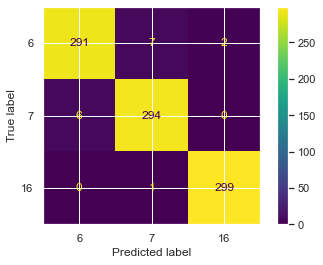

In [118]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_cb_predict)

In [119]:

print("Precision Score : ",precision_score(y_test, y_test_cb_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_cb_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("F1:", f1_score(y_test, y_test_cb_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9822222222222222
Recall Score :  0.9822222222222222
F1: 0.9822222222222222


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


## Segundo modelo

In [120]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [121]:
X_tfid = tfidf.fit_transform(X_train)

C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [122]:
tf_idf_model = RandomForestClassifier(random_state=3)

In [123]:
tf_idf_model.fit(X_tfid, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

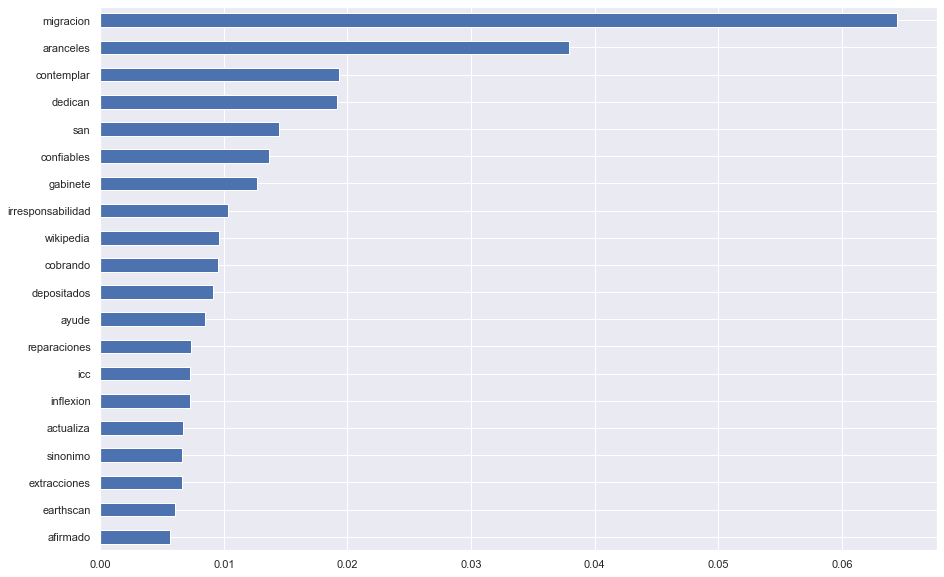

In [124]:
pd.Series(tf_idf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [125]:
y_train_tfidf_predict = tf_idf_model.predict(X_tfid)
y_test_tfidf_predict = tf_idf_model.predict(tfidf.transform(X_test))

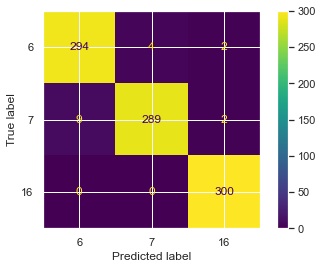

In [126]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [137]:
print("Precision Score : ",precision_score(y_test, y_test_tfidf_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_tfidf_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9811111111111112
Recall Score :  0.9811111111111112


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


# Model Selection

The `RandomizedSearchCV` class is used to perform a randomized search over a hyperparameter space for a given machine learning pipeline.

The `RandomizedSearchCV` object takes several arguments. The first argument, `pipeline`, is the machine learning pipeline that will be optimized. The second argument, `param_grid`, is a dictionary of hyperparameters and their corresponding values that will be searched over. The `n_iter` argument specifies the number of parameter settings that are sampled. In this case, 10 parameter settings will be sampled.

The `scoring` argument is a list of scoring metrics that will be used to evaluate the performance of the machine learning pipeline. In this case, the precision, recall, and F1 score will be used. The `refit` argument specifies which metric to use to choose the best parameters. In this case, the F1 score will be used.

The `cv` argument specifies the number of folds to use for cross-validation. In this case, 10-fold cross-validation will be used. The `return_train_score` argument specifies whether to return the training scores in addition to the test scores. The `verbose` argument specifies the level of verbosity, with a higher value resulting in more output. Finally, the `random_state` argument sets the seed for the random number generator, which ensures that the same results are obtained each time the code is run.

The resulting `RandomizedSearchCV` object can be used to fit the machine learning pipeline to the data and search over the hyperparameter space to find the best combination of hyperparameters that optimize the chosen metric.



In [128]:
pipeline = Pipeline(steps = [
    ("vectorizer", CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)),
    ("classifier", RandomForestClassifier(random_state=4))
])

In [129]:
param_grid = {
    "vectorizer": [CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words), TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words)],
    "vectorizer__lowercase": [True, False],
    "classifier__n_estimators": [50, 100],
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [25, 50, 75, 100]
}

In [130]:
#search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring=["precision", "recall", "f1"], refit="f1", cv=10, return_train_score=True, verbose=1, random_state=5)

In [131]:
#search.fit(X_train, y_train)

In [132]:
#search.best_params_

In [133]:
#y_train_search_predict = search.best_estimator_.predict(X_train)
#y_test_search_predict = search.best_estimator_.predict(X_test)

In [134]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_search_predict)

NameError: name 'y_test_search_predict' is not defined

In [ ]:
print("Precision Score : ",precision_score(y_test, y_test_search_predict, 
                                           pos_label='positive',
                                           average='weighted'))
print("Recall Score : ",recall_score(y_test, y_test_search_predict, 
                                           pos_label='positive',
                                           average='weighted'))
print("F1:", f1_score(y_test, y_test_search_predict, 
                                           pos_label='positive',
                                           average='weighted'))

Precision Score :  0.983346372688478
Recall Score :  0.9833333333333333
F1: 0.9833106656592145


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [ ]:
#export best model
dump(search.best_estimator_, 'pipe.joblib')

['pipe.joblib']

In [ ]:
pipeline_loaded = load('pipe.joblib')

In [ ]:
df_new = pd.read_excel("data/SinEtiquetatest_cat_6716.xlsx")


In [ ]:
df_new['sdg'] = pipeline_loaded.predict(df_new["Textos_espanol"])

In [ ]:
df_new.sample(5)

,Textos_espanol,sdg
944,"Las medidas coercitivas unilaterales son condenadas anualmente por la Asamblea General de la ONU por ser contrarias al derecho internacional y por tener efectos negativos sobre los derechos humanos y la economía de los países en desarrollo. Aunque la doctrina legal generalmente encuentra que las limitaciones de la coerción económica son un área gris del derecho internacional, estas resoluciones podrían ser indicativas de una prohibición emergente. Sin embargo, tras un examen más detallado, parecería que no satisfacen los criterios requeridos, desarrollados por la jurisprudencia y la doctrina internacionales, para establecer una nueva costumbre. Dicho esto, las resoluciones ilustran claramente una división entre los Estados desarrollados y en desarrollo sobre la legitimidad de las sanciones unilaterales que no deben descartarse. Con el fin de comprender cómo surgió esta división y cómo podemos superarla, el artículo procede a abordar los factores sociales que conducen a su creación.",16
168,"PropÃ³sito - Existe poca investigaciÃ³n empÃrica sobre cÃ³mo han respondido las fuerzas de seguridad locales a la ciberdelincuencia. El objetivo de este trabajo es conocer: los organismos encargados de hacer cumplir la ley que los agentes creen que deberían ser los principales responsables de investigar los casos de ciberdelincuencia, sus percepciones sobre la capacidad actual de su organismo para responder a estos delitos y sus creencias sobre las mejores formas de mejorar la respuesta social a la ciberdelincuencia.DiseÃ±o/metodologÃa/enfoque - Los autores encuestaron a agentes de patrulla de los departamentos de policÃa metropolitana de Charlotte-Mecklenburg y Savannah-Chatham.Resultados - Los autores descubrieron que los agentes no creen que las fuerzas de seguridad locales deban ser las principales responsables de tratar los casos de ciberdelincuencia y tienen poca informaciÃ³n sobre cÃ³mo estÃ¡ abordando la ciberdelincuencia la direcciÃ³n superior. Los agentes indicaron que las mejores estrategias para hacer frente a la ciberdelincuencia eran un mayor cuidado de los ciudadanos en línea y mejoras en el sistema legal.Limitaciones/implicaciones de la investigación - Las fuerzas de seguridad locales ...",16
645,"El Consejo Nacional de Investigación Energética (NERC) analizó los ahorros potenciales para diez empresas jordanas (hoteles, bancos y un centro de salud) si adoptaran medidas de eficiencia energética. Actualmente, el gobierno asigna menos del 0,5% de su presupuesto al medio ambiente (PNUMA, 2011). El establecimiento de políticas nacionales de crecimiento verde o planes de desarrollo económico que integren preocupaciones y oportunidades ambientales, y la asignación de fondos públicos adecuados y otros recursos muestran la determinación del gobierno para lograr objetivos de crecimiento verde y pueden ayudar a aumentar la confianza de los inversionistas. Jordania también es signataria de varios convenios ambientales: el Convenio Regional para la Conservación del Mar Rojo (1982), también conocido como el Convenio de Jeddah, el Convenio sobre la Diversidad Biológica (1993), el Convenio sobre Seguridad Nuclear (1994), la Convención de Lucha contra la Desertificación (1996), la Convención de Estocolmo sobre Contaminantes Orgánicos Persistentes (2002) y la Convención sobre Seguridad Nuclear (2009).",7
748,"En comparación con los países nórdicos, los países bálticos muestran precios de electricidad más altos a largo plazo. La principal explicación de esto es una menor penetración de las energías renovables y la fuerte conexión con Europa Continental (a través del interconector LitPol reforzado), que exhiben precios de electricidad más altos. Los recursos energéticos renovables, especialmente la energía eólica, y las opciones de compensación son mejores en los países nórdicos en comparación con los países bálticos y la Europa continental. Por lo tanto, las opciones de importación de electricidad de los países nórdico

In [ ]:
df_new.to_csv("data/ConEtiquetatest_cat_6716.csv", sep=",", index=False, encoding='utf-8')